In [1]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


Упражнение 5.1
Найдем блокнот Jupiter для этой главы и в приложении вычислим автокорреляции для различных lag. Оценим высоту тона вокального чирпа для нескольких времен начала сегмента.

In [2]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

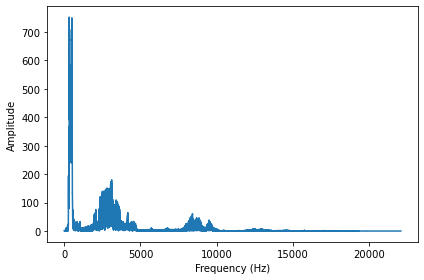

In [4]:
from thinkdsp import decorate

spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

На спектре видны частоты, но для чирпов частотные компоненты размыты.
На спектрограмме показано, как компоненты изменяются с течением времени.

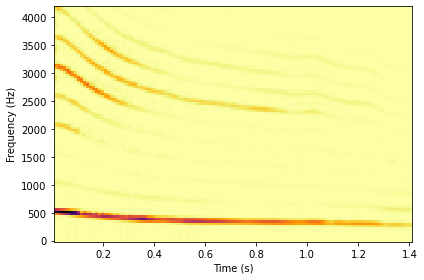

In [5]:
spectro = wave.make_spectrogram(seg_length=1024)
spectro.plot(high=4200)
decorate(xlabel='Time (s)',
                 ylabel='Frequency (Hz)')

Видим основную частоту, начинающуюся около 500 Гц и уменьшающуюся. Некоторые гармоники также видны.
Чтобы оценить высоту тона, рассмотрим более короткий сегмент и напечатаем его спектр.

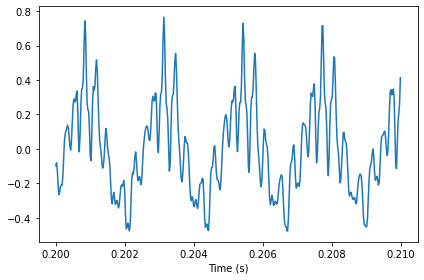

In [6]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
segment.plot()
decorate(xlabel='Time (s)')

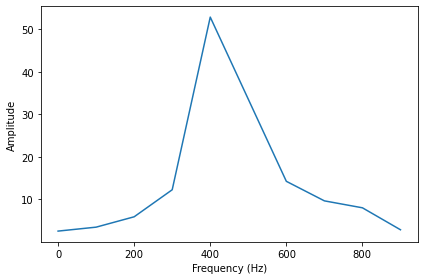

In [7]:
spectrum = segment.make_spectrum()
spectrum.plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Спектр показывает четкий пик около 400 Гц, но мы не можем получить точную оценку частоты, отчасти потому что пик размыт, а еще потому что даже если бы это был идеальный пик, разрешение по частоте не очень хорошее.

Оценим высоту тона точнее, с помощью автокорреляции. Если сигнал периодический, то пик автокорреляции придется на момент, когда lag = периоду.

In [8]:
len(segment), segment.framerate, spectrum.freq_res

(441, 44100, 100.22727272727273)

Каждый элемент спектра охватывает диапазон 100 Гц, поэтому мы не можем получить точную оценку основной частоты.
Для сигналов, которые являются приблизительно периодическими, мы можем добиться большего успеха, оценив продолжительность периода.
Функция ниже показывает сегмент и сдвинутую версию сегмента и вычисляет корреляцию между ними.

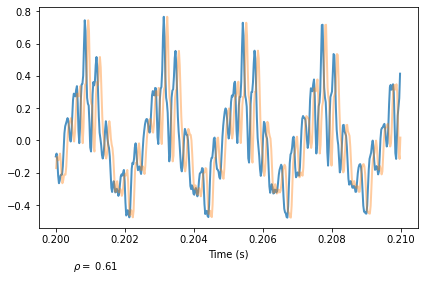

In [11]:
import matplotlib.pyplot as plt

def plot_shifted(wave, offset=0.001, start=0.2):
    segment1 = wave.segment(start=start, duration=0.01)
    segment1.plot(linewidth=2, alpha=0.8)

    # start earlier and then shift times to line up
    segment2 = wave.segment(start=start-offset, duration=0.01)
    segment2.shift(offset)
    segment2.plot(linewidth=2, alpha=0.4)

    corr = segment1.corr(segment2)
    text = r'$\rho =$ %.2g' % corr
    plt.text(segment1.start+0.0005, -0.8, text)
    decorate(xlabel='Time (s)')

plot_shifted(wave, 0.0001)

При небольшом сдвиге сегменты так же умеренно коррелированы. По мере увеличения сдвига корреляция на некоторое время падает, затем снова возрастает, достигая максимума, когда сдвиг равен периоду сигнала.

Функция autocorr автоматизирует процесс поиска сдвига, который максимизирует корреляцию, вычисляя корреляцию для каждого возможного lag, вплоть до половины длины волны.

In [14]:
import numpy as np

def serial_corr(wave, lag=1):
    N = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:N-lag]
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [15]:
wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)

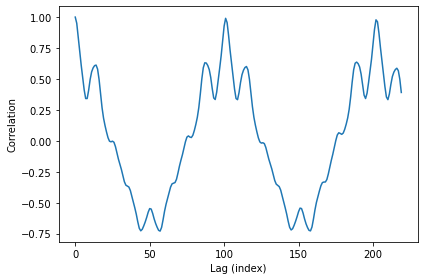

In [16]:
lags, corrs = autocorr(segment)
plt.plot(lags, corrs)
decorate(xlabel='Lag (index)', ylabel='Correlation')

Первый пик (отличный от 0) находится вблизи lag=100.
Используем argmax, чтобы найти индекс этого пика.

In [17]:
low, high = 90, 110
lag = np.array(corrs[low:high]).argmax() + low
lag

101

Преобразуем индекс во время в секундах.

In [18]:
period = lag / segment.framerate
period

0.002290249433106576

Учитывая период в секундах, мы можем вычислить частоту.

In [19]:
frequency = 1 / period
frequency

436.63366336633663

Искомая основная частота - 437 Гц. Для оценки точности подбора можно запустить тот же расчет с lag = 100 и 102, соответсвующими частотами 432 и 441 Гц. Разрешение по частоте у способа с автокорреляцией менее 10 Гц, а у спектрального - 100 Гц. В музыкальных терминах ожидаемая ошибка - около 30 центов (треть полутона).

In [20]:
segment.framerate / 102, segment.framerate / 100

(432.3529411764706, 441.0)

Упражнение 5.2
Пример кода в главе 05.ipynb показывает, как использовать автокорреляцию для оценки основной частоты периодического сигнала. Инкапсулируем этот код в функцию, называемую estimate_fundamental, и используем ее для отслеживания высоты тона записанного звука.

Попробуем наложить свои оценки высоты тона на спектрограмму записи.

In [21]:
from thinkdsp import read_wave

wave = read_wave('28042__bcjordan__voicedownbew.wav')
wave.normalize()
wave.make_audio()

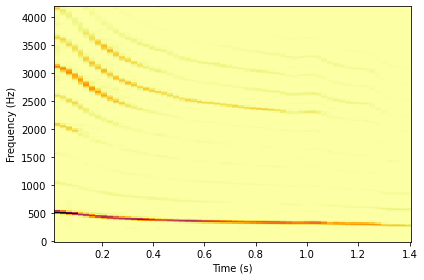

In [22]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)',
         ylabel='Frequency (Hz)')

Ниже представлена функция, которая инкапсулирует код из главы 5. Найти первый, самый высокий пик в автокорреляционной функции довольно сложно. Укажем диапазон задержек для поиска.

In [23]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

In [24]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

436.63366336633663

Ниже представлен цикл, который отслеживает высоту звука по выборке.
ts - это средние точки каждого сегмента.

In [25]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Ниже показана кривая отслеживания высоты тона, наложенная на спектрограмму.

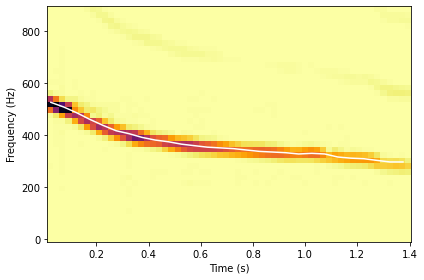

In [26]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)',
                     ylabel='Frequency (Hz)')

Упражнение 5.3
Используя историческую цену биткоинов, вычислим автокорреляцию цен на биткоин. Узнаем, насколько быстро отключается функция автокорреляции и есть ли свидетельства периодического поведения.

In [27]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-2020_price-CoinDesk.csv',
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

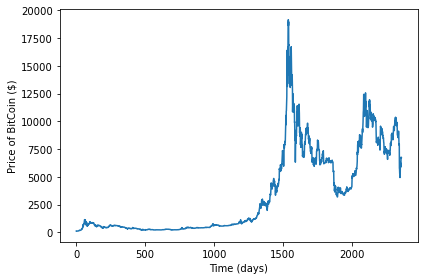

In [28]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

Ниже функция автокорреляции, использующая статистическое определение, которое является несмещенным, нормализованным и стандартизирует, то есть оно сдвигает среднее значение к нулю, делит на стандартное отклонение и делит сумму на N.

In [29]:
def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [30]:
def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

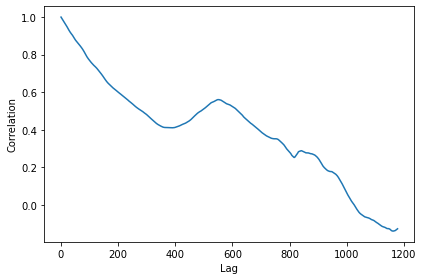

In [31]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

Автокорреляционная функция медленно снижается по мере увеличения задержки, похоже на розовый шум. То есть нет признаков периодического процесса.

Упражнение 5.4
Скачаем блокнот под названием [saxophone.ipynb](https://github.com/AllenDowney/ThinkDSP/blob/master/code/saxophone.ipynb) и запустим его. Поэкспериментируем с разными сегментами.